In [ ]:
!pip install graphlearning


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal as mult_norm
import graphlearning.weightmatrix as wm
import graphlearning.graph
import graphlearning.ssl as ssl
import time
from scipy import sparse
import json
import pandas as pd
import math
import os
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
import shutil
from labled_point import LabeledPoint
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


In [ ]:
np.random.seed(91)

In [ ]:
# Helper functions

def EuclideanDist(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**(1/2)
def NearestMean(point, means):
    return np.argmin([EuclideanDist(point, means[j]) for j in range(len(means))])
def Generate(n_per_cluster, cov, mean_arr):
    """ Create 3 gaussian clusters with given mean, covariance, and number of clusters
    """
    x1, y1 = mult_norm(mean_arr[0], cov, n_per_cluster).T
    x2, y2 = mult_norm(mean_arr[1], cov, n_per_cluster).T
    x3, y3 = mult_norm(mean_arr[2], cov, n_per_cluster).T
    x = [x1, x2, x3]
    y = [y1, y2, y3]
    data = [list(zip(x[0], y[0])), list(zip(x[1], y[1])), list(zip(x[2], y[2]))]
    data = data[0] + data[1] + data[2]
    return data

In [ ]:
# Generate Data
n_per_cluster = 500
cov = [[.1, 0], [0, .1]]
mean1 = [.6, .4]
mean2 = [.9, -1.7]
#mean3 = [-.2, .5]
mean3 = [-.6, .5]
mean_arr = [mean1, mean2, mean3]
data = Generate(n_per_cluster, cov, mean_arr)

# Relabel for discriminative clustering
labels = np.array([NearestMean(data[i], np.array(mean_arr)) for i in range(len(data))])
print("Unique labels in data:", np.unique(labels))

Unique labels in data: [0 1 2]


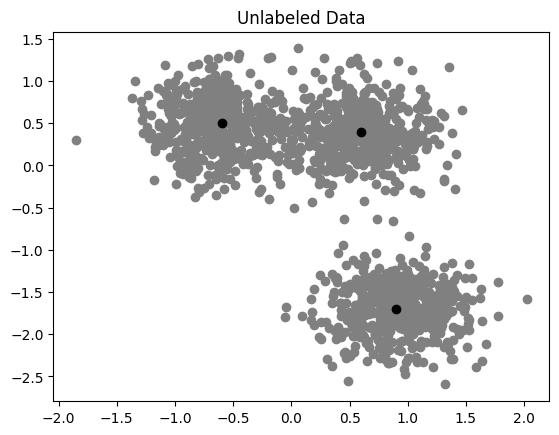

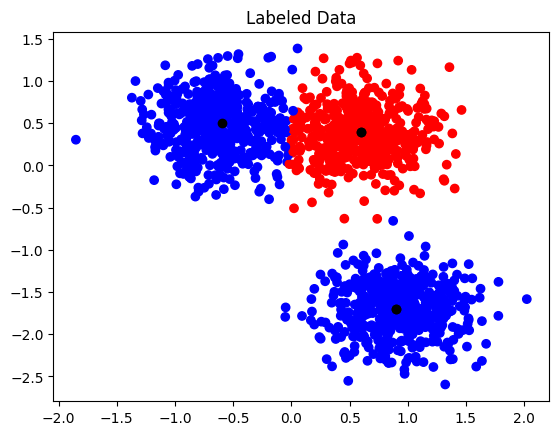

In [ ]:
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c="gray")
plt.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c="k")
plt.title("Unlabeled Data")
plt.show()

# Plot labeled data
c_map = {0: 'r', 1: 'b', 2: 'b'}
color_arr = [c_map[label] for label in labels]
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=color_arr)
plt.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c='k')
plt.plot(mean1[0], mean1[1], 'ko')
plt.plot(mean2[0], mean2[1], 'ko')
plt.title("Labeled Data")
plt.show()

csr


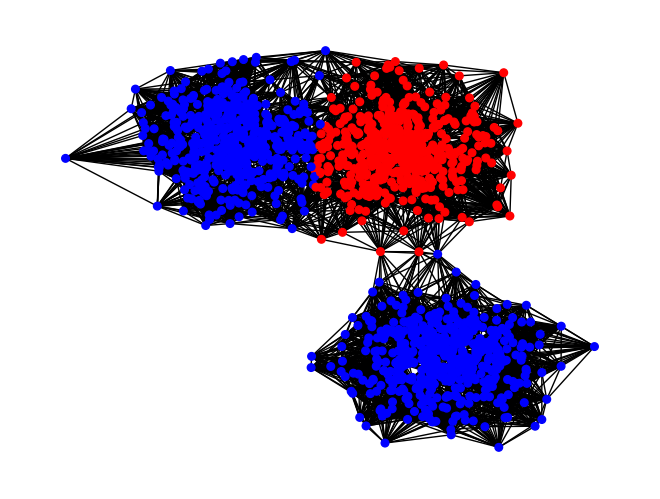

In [ ]:
def create_graph(n):
  A = wm.knn(np.array(data), k=n, kernel="gaussian")
  # remove edges from node to itself
  A.setdiag(np.zeros(len(data)))
  A.eliminate_zeros()
  # Create networkx graph
  H = nx.from_scipy_sparse_array(A)
  return H, A
def get_all_positions():
  return {i: data[i] for i in range(len(data))}
n = 30
H_original, A = create_graph(n)
print(A.getformat())
pos = get_all_positions()
nx.draw(H_original, pos=pos, node_size=[30 for i in range(len(data))], node_color=color_arr)

In [ ]:
eigenvectors_list = []
graphs = []
graph = graphlearning.graph(A, labels=labels, label_names=c_map)
L = graph.laplacian()
L_one_eigenvalues, L_one_eigenvectors = graph.eigen_decomp(method='exact', k=3)
eigv_2d = L_one_eigenvectors[:, 1:3]
eigenvectors_list.append(eigv_2d)
graphs.append(H_original.copy())
L_one_eigenvalues = np.array(L_one_eigenvalues)

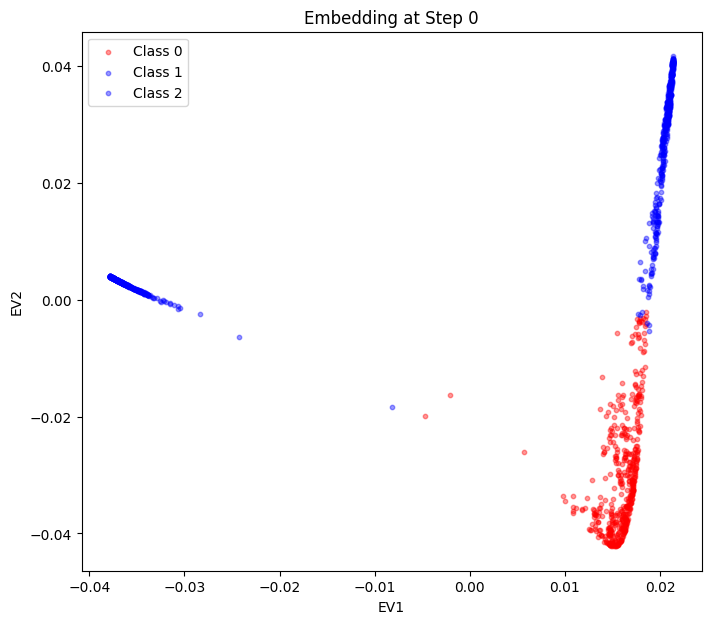

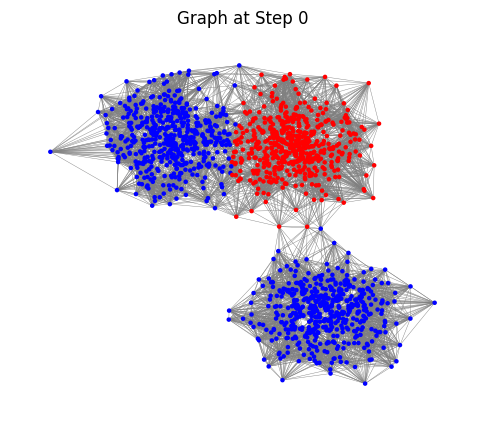

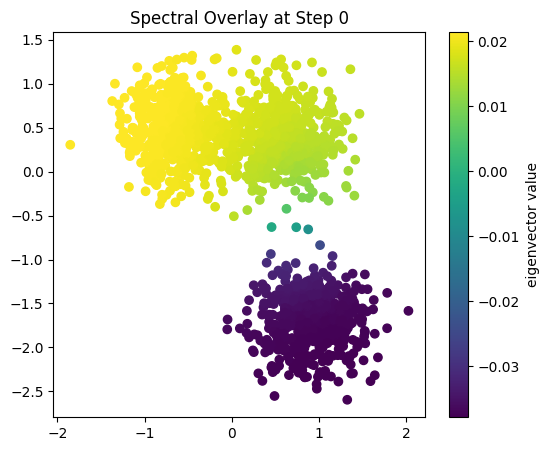

In [ ]:
# --- Plot Step 0 Embedding ---
fig = plt.figure(figsize=(8, 7))

for label_class in set(labels):
    class_indices = [i for i in range(len(labels)) if labels[i] == label_class]
    points = eigv_2d[class_indices]
    color = c_map.get(label_class, 'gray')
    plt.scatter(points[:, 0], points[:, 1], label=f"Class {label_class}",
                color=color, alpha=0.4, s=10)

plt.title("Embedding at Step 0")
plt.xlabel("EV1")
plt.ylabel("EV2")
plt.legend()
plt.show()

# --- Plot Step 0 Graph ---
plt.figure(figsize=(6, 5))
node_colors = [c_map.get(labels[n], 'gray') for n in H_original.nodes()]
pos_edges = [(u, v) for u, v, d in H_original.edges(data=True) if d['weight'] > 0]
neg_edges = [(u, v) for u, v, d in H_original.edges(data=True) if d['weight'] < 0]

nx.draw_networkx_nodes(H_original, pos=pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(H_original, pos=pos, edgelist=pos_edges, edge_color='grey', width=0.3)
nx.draw_networkx_edges(H_original, pos=pos, edgelist=neg_edges, edge_color='green', width=0.5)

plt.title("Graph at Step 0")
plt.axis('off')
# plt.savefig(f"{graph_frames_dir}/graph_step_000.png")
plt.show()
plt.close()

# --- Plot step 0 spectral overlay ---
plt.figure(figsize=(6, 5))
eigenvector_one = eigv_2d[:, 0]
eigenvector_two = eigv_2d[:, 1]
scatter = plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=eigenvector_one, cmap='viridis')
plt.title("Spectral Overlay at Step 0")
plt.colorbar(scatter, label = "eigenvector value")
# plt.savefig(f"{spectral_overlay_frames_dir}/spectral_overlay_step_000.png")
plt.show()
plt.close()

In [ ]:
fiddler_vector = eigenvector_one
threshold = np.median(fiddler_vector)
y_true = labels

# since fiddler vector usually splits data into two classes: positive vs negative
y_pred = (fiddler_vector > threshold).astype(int)

# merge 1 and 2 into a single class (say, class 1)
merge_map = {0: 0, 1: 1, 2: 1}
y_true_mapped = np.array([merge_map[l] for l in y_true])

# now compute accuracy on the mapped labels
accuracy_num = accuracy_score(y_true_mapped, y_pred, normalize = False)
accuracy = accuracy_num / len(y_true_mapped)
print("number correctly predicted: ", accuracy_num)
print("accuracy: ", accuracy)

number correctly predicted:  743.0
accuracy:  0.49533333333333335


In [ ]:
fiddler_vector = eigenvector_one
y_true = labels

# KMeans clustering on the fiddler vector
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(fiddler_vector.reshape(-1, 1))

# merge 1 and 2 into a single class, class 1
merge_map = {0: 0, 1: 1, 2: 1}
y_true_mapped = np.array([merge_map[l] for l in y_true])

# find which version give highest score since labels may be flipped
acc1 = accuracy_score(y_true_mapped, y_pred)
acc2 = accuracy_score(y_true_mapped, 1 - y_pred)
if acc2 > acc1:
    y_pred = 1 - y_pred

# compute accuracy
accuracy_num = accuracy_score(y_true_mapped, y_pred, normalize=False)
accuracy = accuracy_num / len(y_true_mapped)

print("number correctly predicted:", accuracy_num)
print("accuracy:", accuracy)

number correctly predicted: 1006.0
accuracy: 0.6706666666666666


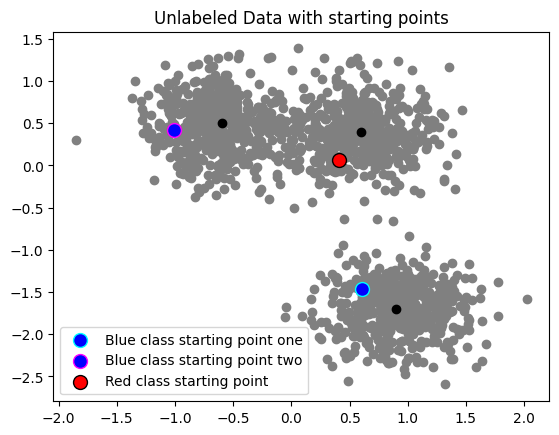

In [ ]:
# get points and label points
all_labeled_center_points = []
all_labled_center_points_indices = []

all_labled_ring_points = []
all_labled_ring_points_indices = []

# so I don't have to always start at the beginning of the notebook
H = H_original

starting_blue_index_one = 500
starting_blue_labeled_point_one = LabeledPoint(data[500][0], data[500][1],
                                           labels[500])
starting_blue_index_two = 1000
starting_blue_labeled_point_two = LabeledPoint(data[1000][0], data[1000][1],
                                           labels[1000])
starting_red_index = 0
starting_red_labeled_point = LabeledPoint(data[0][0],data[0][1],
                                          labels[0])
# add labeled points to list
all_labeled_center_points.append(starting_blue_labeled_point_one)
all_labeled_center_points.append(starting_blue_labeled_point_two)
all_labeled_center_points.append(starting_red_labeled_point)

# add labeled points indicies to list
all_labled_center_points_indices.append(starting_blue_index_one)
all_labled_center_points_indices.append(starting_blue_index_two)
all_labled_center_points_indices.append(starting_red_index)

# plot data
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c="gray")
plt.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c="k")

# Highlight the chosen points
plt.scatter(starting_blue_labeled_point_one.x_pos,
            starting_blue_labeled_point_one.y_pos,
            c=c_map.get(starting_blue_labeled_point_one.label), s=100,
            edgecolors='cyan', label='Blue class starting point one')

plt.scatter(starting_blue_labeled_point_two.x_pos,
            starting_blue_labeled_point_two.y_pos,
            c=c_map.get(starting_blue_labeled_point_two.label), s=100,
            edgecolors='magenta', label='Blue class starting point two')

plt.scatter(starting_red_labeled_point.x_pos,
            starting_red_labeled_point.y_pos,
            c = c_map.get(starting_red_labeled_point.label), s=100,
            edgecolors='black', label='Red class starting point')


plt.title("Unlabeled Data with starting points")
plt.legend()
plt.show()

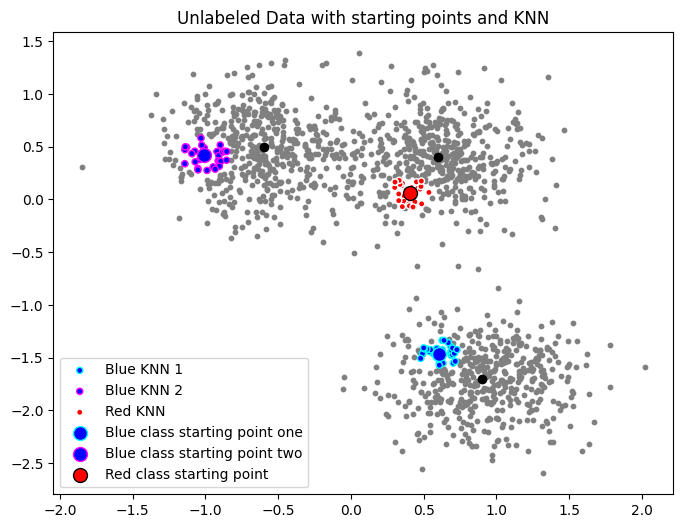

In [ ]:
indices, distances = wm.knnsearch(np.array(data), k=n)

# methods to get knn indices and distances for a specific point
def get_knn_indices_for_point(point_index, indices):
    return indices[point_index]
def get_knn_distances_for_point(point_index, distances):
    return distances[point_index]

blue_starting_knn_ind_one = get_knn_indices_for_point(
    starting_blue_index_one, indices)

blue_starting_knn_ind_two = get_knn_indices_for_point(
    starting_blue_index_two, indices)

red_starting_knn_ind = get_knn_indices_for_point(
    starting_red_index, indices)

# method to create a list of knn labeled points
def create_list_of_knn_labeled_point_objs(data, labels, index_list, k = 30):
  labeled_point_list = []
  for i in range(n):
    labeled_point_list.append(LabeledPoint(data[index_list[i]][0],
                                           data[index_list[i]][1],
                                           labels[index_list[i]]))
  return labeled_point_list
# Create LabeledPoint objects for the KNNs
labeled_list_of_blue_knn_one = create_list_of_knn_labeled_point_objs(
    data, labels, blue_starting_knn_ind_one, k = n)
labeled_list_of_blue_knn_two = create_list_of_knn_labeled_point_objs(
    data, labels, blue_starting_knn_ind_two, k = n)
labeled_list_of_red_knn = create_list_of_knn_labeled_point_objs(
    data, labels, red_starting_knn_ind, k = n)

# add labeled points to list
all_labled_ring_points.append(labeled_list_of_blue_knn_one)
all_labled_ring_points.append(labeled_list_of_blue_knn_two)
all_labled_ring_points.append(labeled_list_of_red_knn)

#add labeled indicies to list
all_labled_ring_points_indices.append(blue_starting_knn_ind_one)
all_labled_ring_points_indices.append(blue_starting_knn_ind_two)
all_labled_ring_points_indices.append(red_starting_knn_ind)


fig, ax = plt.subplots(figsize=(8, 6))  # create figure + axis


# Base scatter: all data
ax.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c="gray", s=10)
ax.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c="k")

# Plot the k-nearest neighbors for each starting point
ax.scatter([p.x_pos for p in labeled_list_of_blue_knn_one],
           [p.y_pos for p in labeled_list_of_blue_knn_one],
           c=[c_map.get(p.label) for p in labeled_list_of_blue_knn_one],
           s=20, edgecolors='cyan', label='Blue KNN 1')

ax.scatter([p.x_pos for p in labeled_list_of_blue_knn_two],
           [p.y_pos for p in labeled_list_of_blue_knn_two],
           c=[c_map.get(p.label) for p in labeled_list_of_blue_knn_two],
           s=20, edgecolors='magenta', label='Blue KNN 2')

ax.scatter([p.x_pos for p in labeled_list_of_red_knn],
           [p.y_pos for p in labeled_list_of_red_knn],
           c=[c_map.get(p.label) for p in labeled_list_of_red_knn],
           s=20, edgecolors='white', label='Red KNN')

# Highlight the starting points
ax.scatter(starting_blue_labeled_point_one.x_pos,
           starting_blue_labeled_point_one.y_pos,
           c=c_map.get(starting_blue_labeled_point_one.label), s=100,
           edgecolors='cyan', label='Blue class starting point one')

ax.scatter(starting_blue_labeled_point_two.x_pos,
           starting_blue_labeled_point_two.y_pos,
           c=c_map.get(starting_blue_labeled_point_two.label), s=100,
           edgecolors='magenta', label='Blue class starting point two')

ax.scatter(starting_red_labeled_point.x_pos,
           starting_red_labeled_point.y_pos,
           c=c_map.get(starting_red_labeled_point.label), s=100,
           edgecolors='black', label='Red class starting point')

ax.set_title("Unlabeled Data with starting points and KNN")
ax.legend()

plt.show()


In [ ]:
"""
three cases:

Case One: the edge is an original edge from the graph creation and the points
on each end of the edge are labeled such that they are different classes or
where the center point of one is a neighbor of the other.

In this case delete the edge.

Case Two: When two labeled points of different classes share a ring point.

In this case the edges(2 of them) going from center node to "shared" node to
other center node are decreased by a factor of 1/2.

Case Three: When two ring points of differently labeled center points share an
edge. Important to make sure that the edge nodes are of different classes as
well.

In this case the edge shared by the two ring points/nodes is decreased by a
factor of 3/4.
"""

def identify_case_one(adj_matrix, point_idx_one, point_idx_two):
  if(labels[point_idx_one] == labels[point_idx_two]):
    return False
  else:
    return (adj_matrix[point_idx_one, point_idx_two] > 0) or (
        adj_matrix[point_idx_two, point_idx_one] > 0)

# this method gives me shared ring points/nodex(indexes)
def identify_case_two(point_idx_one, point_idx_two):
    # Skip if same class
    if labels[point_idx_one] == labels[point_idx_two]:
        return False, []
    point_one_knn = get_knn_indices_for_point(point_idx_one, indices)
    point_two_knn = get_knn_indices_for_point(point_idx_two, indices)

    # intersection of the two knn lists
    node_similarity_list = list(set(point_one_knn) and set(point_two_knn))

    if len(node_similarity_list) == 0:
        return False, []
    else:
        return True, node_similarity_list

# this method gives me shared edges between ring points(adj_matrix_indidces)
def identify_case_three(adj_matrix, point_idx_one, point_idx_two):
    # Skip if same class
    if labels[point_idx_one] == labels[point_idx_two]:
        return False, []

    point_one_knn = get_knn_indices_for_point(point_idx_one, indices)
    point_two_knn = get_knn_indices_for_point(point_idx_two, indices)

    edge_similarity_list = []
    for i in range(len(point_one_knn)):
        for j in range(len(point_two_knn)):
            if (adj_matrix[point_one_knn[i], point_two_knn[j]] > 0) or (adj_matrix[point_two_knn[j], point_one_knn[i]] > 0):
                edge_similarity_list.append(
                    (point_one_knn[i], point_two_knn[j]))

    if len(edge_similarity_list) == 0:
        return False, []
    else:
        return True, edge_similarity_list

# case one action is to delete edge between two labeled center nodes
def case_one_action(adj_matrix, point_idx_one, point_idx_two):
    adj_matrix = adj_matrix.tolil()
    if adj_matrix[point_idx_one, point_idx_two] > 0:
        adj_matrix[point_idx_one, point_idx_two] = 0

    if adj_matrix[point_idx_two, point_idx_one] > 0:
        adj_matrix[point_idx_two, point_idx_one] = 0
    adj_matrix = adj_matrix.tocsr()
    adj_matrix.eliminate_zeros()
    return adj_matrix



# case two action is to reduce weight by a factor of 1/2
def case_two_action(adj_matrix, point_idx_one, point_idx_two,
                    node_similarity_list):
  for node in node_similarity_list:
    if adj_matrix[node, point_idx_one] > 0:
      adj_matrix[node, point_idx_one] *= 0.5
    if adj_matrix[node, point_idx_two] > 0:
      adj_matrix[node, point_idx_two] *= 0.5
    if adj_matrix[point_idx_one, node] > 0:
      adj_matrix[point_idx_one, node] *= 0.5
    if adj_matrix[point_idx_two, node] > 0:
      adj_matrix[point_idx_two, node] *= 0.5
  return adj_matrix


# case three action is to reduce weight by a factor of 3/4
def case_three_action(adj_matrix, edge_similarity_list):
  for node_one, node_two in edge_similarity_list:
    if adj_matrix[node_one, node_two] > 0:
      adj_matrix[node_one, node_two] *= 0.75
    if adj_matrix[node_two, node_one] > 0:
      adj_matrix[node_two, node_one] *= 0.75
  return adj_matrix

# case four action is to add an edge between two labeled center nodes
# assumes point_idx_one and point_idx_two are of the same class via
# color map
def case_four_action(adj_matrix, point_idx_one, point_idx_two, labels, c_map):
    adj_matrix = adj_matrix.tolil()

    # connect center nodes (or strengthen if already connected)
    if point_idx_two in adj_matrix.rows[point_idx_one]:
        # strengthen existing edge
        adj_matrix[point_idx_one, point_idx_two] *= 1.5
        adj_matrix[point_idx_two, point_idx_one] *= 1.5
    else:
        # add new edge
        adj_matrix[point_idx_one, point_idx_two] = 1
        adj_matrix[point_idx_two, point_idx_one] = 1

    # get neighbor sets
    point_one_knn = get_knn_indices_for_point(point_idx_one, indices)
    point_two_knn = get_knn_indices_for_point(point_idx_two, indices)

    for node in point_one_knn:
        for node2 in point_two_knn:
            # don’t connect the two central labeled points directly to each
            # other’s neighborhoods, only connect their surrounding neighbors
            # to each other.
            if node in (point_idx_one, point_idx_two) or node2 in (point_idx_one, point_idx_two):
                continue
            # if from node is the same as node2, hopfully prevents self edges
            if node == node2:
                continue

            # only connect nodes with same label
            if c_map.get(labels[node]) == c_map.get(labels[node2]):
                if node2 in adj_matrix.rows[node]:
                    # strengthen existing edge, idk by what value though
                    adj_matrix[node, node2] *= 1.5
                    adj_matrix[node2, node] *= 1.5
                else:
                    # add new edge
                    adj_matrix[node, node2] = 1
                    adj_matrix[node2, node] = 1

    # clean up and return in CSR format
    adj_matrix = adj_matrix.tocsr()
    adj_matrix.eliminate_zeros()
    return adj_matrix

In [ ]:
"""
strategy one for finding decision boundaries
Idea:
Given that I have three labeled points, assume that points close to labeled
points are of the same class. Assign a probablity that a point is a a specific
class. The probablity will range from 1 to .5, 1 being a point are the same as
the labeled point. .5 being a point can be part of either class red or blue as
points get futher fomrm labeled points the probablity will decrease.

choose points with probablity close to .5 as next points to label as hopefully
they will be close to a decision boundaray

add edge weights if new points are of the same class, or if points match one of
the 3 cases do perform the action of one that case

hopefully overtime i'll get a good decision boundary

things to consider:
for this technique how crucial is the positioning of the starting points?
if I start with different points will a ending decision boundary be different?
if I start with the same points will a ending decision boundary be the same?
If I start with the same points and the decision boundary is the same does it
take a similar number of iterations to converge or not?

Question for Kevin:
Currently all this code is to find the decision boundary. Do you want me to do
the adding, deleting and changing weights while I'm finding the boundary, or
Should I run the decision boundary algorithm for a couple of rounds to get a
good boundary while not changing the wieghts then do the adding, deleting
and changing weights once I've found a boundary?.
"""

#helper methods

def map_to_actual_classes(labels, class_map):
    unique_colors = list(set(class_map.values()))
    unique_colors.sort()

    color_to_class = {color: idx for idx, color in enumerate(unique_colors)}

    mapped_labels = np.array(
        [color_to_class[class_map[label]] for label in labels])

    return mapped_labels, unique_colors

def label_propagation(AdjMatrix, y, class_map):
    # Get labeled indices
    train_indices = np.where(y != -1)[0]
    # Get their labels
    train_labels = y[train_indices]

    print(f"Original train labels: {train_labels}")

    # Get the unique labels should just be 0,1 - 0:red, 1:blue
    mapped_train_labels, class_names = map_to_actual_classes(
        train_labels, class_map)
    n_classes = len(class_names)

    print(f"Mapped train labels: {mapped_train_labels}")
    print(f"Class names: {class_names}")

    # Get class priors, for now it will be .5 red, .5 blue,
    # actual is .33 red, .66 blue
    class_priors = np.ones(n_classes) / n_classes
    print(f"Class priors: {class_priors}")

    model = ssl.laplace(AdjMatrix, class_priors=class_priors)
    probabilities = model.fit(train_indices, mapped_train_labels)

    return probabilities, class_names

def find_top_k_uncertain_points(probabilities, y, k=3):
    """Pick top-k most uncertain unlabeled points"""
    unlabeled_indices = np.where(y == -1)[0]
    max_probs = np.max(probabilities[unlabeled_indices], axis=1)
    uncertainty = 1 - max_probs
    top_k_indices = np.argsort(-uncertainty)[:k]
    top_indices = unlabeled_indices[top_k_indices]
    return top_indices, uncertainty[top_k_indices]


Original train labels: [0 1 2]
Mapped train labels: [1 0 0]
Class names: ['b', 'r']
Class priors: [0.5 0.5]
Original train labels: [0 2 2 2 1 2]
Mapped train labels: [1 0 0 0 0 0]
Class names: ['b', 'r']
Class priors: [0.5 0.5]
Original train labels: [0 0 2 2 0 2 0 1 2]
Mapped train labels: [1 1 0 0 1 0 1 0 0]
Class names: ['b', 'r']
Class priors: [0.5 0.5]
Original train labels: [0 0 0 0 0 2 2 0 2 0 1 2]
Mapped train labels: [1 1 1 1 1 0 0 1 0 1 0 0]
Class names: ['b', 'r']
Class priors: [0.5 0.5]
Original train labels: [0 0 0 0 0 2 2 0 2 0 0 1 2 0 2]
Mapped train labels: [1 1 1 1 1 0 0 1 0 1 1 0 0 1 0]
Class names: ['b', 'r']
Class priors: [0.5 0.5]
Original train labels: [0 0 0 0 0 2 2 0 2 2 0 0 1 2 0 2 2 2]
Mapped train labels: [1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0]
Class names: ['b', 'r']
Class priors: [0.5 0.5]
Original train labels: [0 0 0 0 0 2 2 0 2 2 0 0 1 1 2 0 2 2 2 2 2]
Mapped train labels: [1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0]
Class names: ['b', 'r']
Class priors: [0

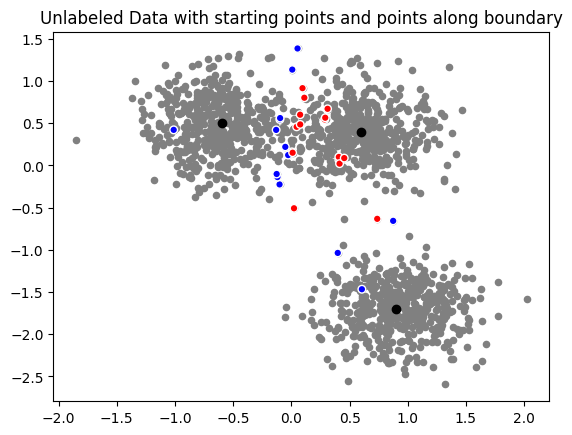

In [ ]:
# run it!
# Initialize labels, -1 means no label
y = np.full(len(data), -1)
# start with 10 rounds
for round in range(9):
  # get all labeled indices
  y[all_labled_center_points_indices] = labels[all_labled_center_points_indices]

  # get 3 new points hopefully close to a boundary, fingers crossed
  probabilities, class_names = label_propagation(A, y, c_map)

  # Find uncertain points
  new_points, uncertainties = find_top_k_uncertain_points(probabilities, y, k=3)

  # first loop against other points in new_points
  for point_one in new_points:
    for point_two in new_points:
        # Case One
        if identify_case_one(A, point_one, point_two):
            A = case_one_action(A, point_one, point_two)

        # Case Two
        case2_flag, node_similarity_list = identify_case_two(point_one, point_two)
        if case2_flag:
            A = case_two_action(A, point_one, point_two, node_similarity_list)

        # Case Three
        case3_flag, edge_similarity_list = identify_case_three(A, point_one, point_two)
        if case3_flag:
            A = case_three_action(A, edge_similarity_list)

        # Case Four (same class) via color map
        if c_map.get(labels[point_one]) == c_map.get(labels[point_two]):
            A = case_four_action(A, point_one, point_two, labels, c_map)

  # second loop for new points against older points
  # I wonder if adding the new_points to the all_points list first is better
  # than doing two loops, idk but I think this will work
  for new_point in new_points:
    for other_point in all_labled_center_points_indices:
      if new_point == other_point:
          continue  # skip self-pair

      # Case One
      if identify_case_one(A, new_point, other_point):
          A = case_one_action(A, new_point, other_point)

      # Case Two
      case2_flag, node_similarity_list = identify_case_two(new_point, other_point)
      if case2_flag:
          A = case_two_action(A, new_point, other_point, node_similarity_list)

      # Case Three
      case3_flag, edge_similarity_list = identify_case_three(A, new_point, other_point)
      if case3_flag:
          A = case_three_action(A, edge_similarity_list)

      # Case Four (same-class centers) via color map
      if c_map.get(labels[new_point]) == c_map.get(labels[other_point]):
          A = case_four_action(A, new_point, other_point, labels, c_map)

  # add new points to list of all labeled points and indicies
  for point in new_points:
    all_labeled_center_points.append(LabeledPoint(data[point][0],
                                                  data[point][1],labels[point]))
    all_labled_center_points_indices.append(point)
# update H to match A after all the changes
H = nx.from_scipy_sparse_array(A)
# update the laplacian aswell
L = csgraph.laplacian(A, normed=False)

# plot data
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c="gray", s= 20)
plt.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c="k")

plt.scatter([p.x_pos for p in all_labeled_center_points],
          [p.y_pos for p in all_labeled_center_points],
          c=[c_map.get(p.label) for p in all_labeled_center_points],
          s=30, edgecolors='white', label='labeled points')
plt.title("Unlabeled Data with starting points and points along boundary")
plt.show()


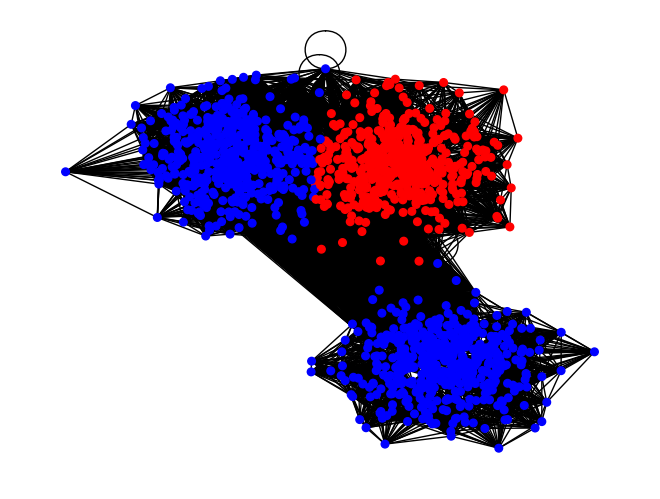

In [ ]:
nx.draw(H, pos=pos, node_size=[30 for i in range(len(data))], node_color=color_arr)

In [ ]:
# eigen-decomposition
vals, vecs = eigsh(L, k=3, sigma=0.0, which="LM")
L_eigenvalues_iter = np.array(vals)
L_eigenvectors_iter = np.array(vecs)

eigv_2d = L_eigenvectors_iter[:, 1:3]
eigenvectors_list.append(eigv_2d)
graphs.append(H.copy())

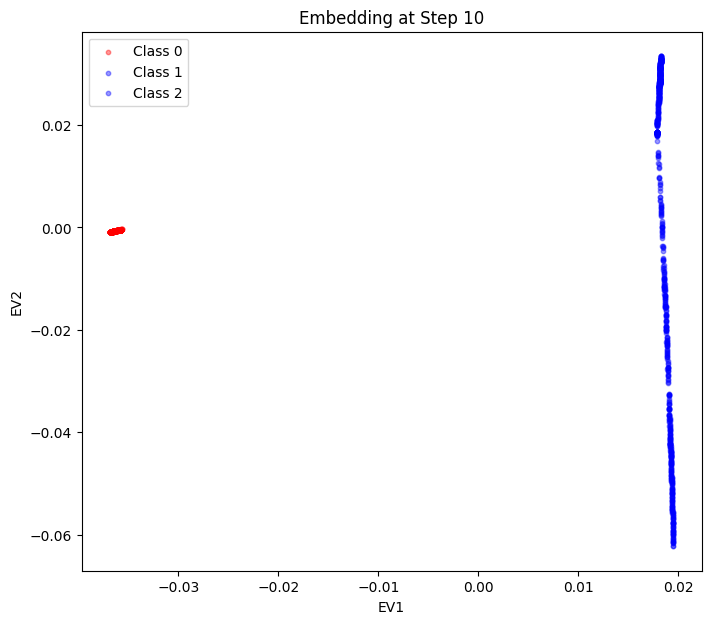

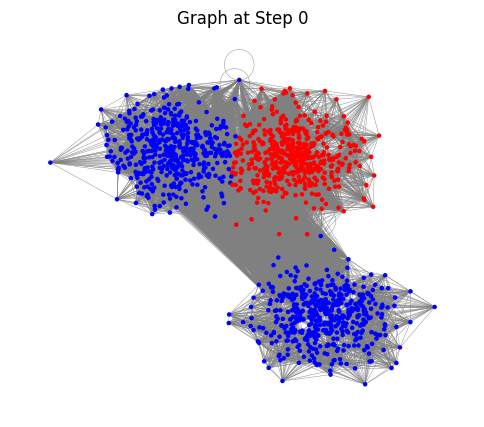

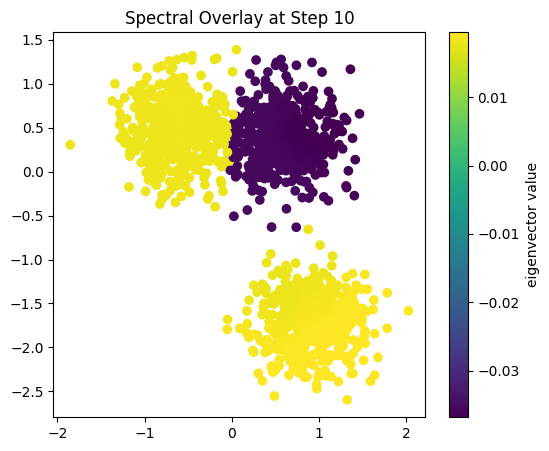

In [ ]:

fig = plt.figure(figsize=(8, 7))

for label_class in set(labels):
    class_indices = [i for i in range(len(labels)) if labels[i] == label_class]
    points = eigv_2d[class_indices]
    color = c_map.get(label_class, 'gray')
    plt.scatter(points[:, 0], points[:, 1], label=f"Class {label_class}",
                color=color, alpha=0.4, s=10)

plt.title("Embedding at Step 10")
plt.xlabel("EV1")
plt.ylabel("EV2")
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
node_colors = [c_map.get(labels[n], 'gray') for n in H.nodes()]
pos_edges = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] > 0]
neg_edges = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] < 0]

nx.draw_networkx_nodes(H, pos=pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(H, pos=pos, edgelist=pos_edges, edge_color='grey', width=0.3)
plt.title("Graph at Step 0")
plt.axis('off')
# plt.savefig(f"{graph_frames_dir}/graph_step_000.png")
plt.show()
plt.close()

plt.figure(figsize=(6, 5))
eigenvector_one = eigv_2d[:, 0]
eigenvector_two = eigv_2d[:, 1]
scatter = plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=eigenvector_one, cmap='viridis')
plt.title("Spectral Overlay at Step 10")
plt.colorbar(scatter, label = "eigenvector value")
# plt.savefig(f"{spectral_overlay_frames_dir}/spectral_overlay_step_000.png")
plt.show()
plt.close()

In [ ]:
fiddler_vector = eigenvector_one
threshold = np.median(fiddler_vector)
y_true = labels

# since fiddler vector usually splits data into two classes: positive vs negative
y_pred = (fiddler_vector > threshold).astype(int)

# merge 1 and 2 into a single class (say, class 1)
merge_map = {0: 0, 1: 1, 2: 1}
y_true_mapped = np.array([merge_map[l] for l in y_true])

# now compute accuracy on the mapped labels
accuracy_num = accuracy_score(y_true_mapped, y_pred, normalize = False)
accuracy = accuracy_num / len(y_true_mapped)
print("number correctly predicted: ", accuracy_num)
print("accuracy: ", accuracy)


number correctly predicted:  1257.0
accuracy:  0.838


In [ ]:
fiddler_vector = eigenvector_one
y_true = labels

# KMeans clustering on the fiddler vector
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(fiddler_vector.reshape(-1, 1))

# merge 1 and 2 into a single class, class 1
merge_map = {0: 0, 1: 1, 2: 1}
y_true_mapped = np.array([merge_map[l] for l in y_true])

# find which version give highest score since labels may be flipped
acc1 = accuracy_score(y_true_mapped, y_pred)
acc2 = accuracy_score(y_true_mapped, 1 - y_pred)
if acc2 > acc1:
    y_pred = 1 - y_pred

# compute accuracy
accuracy_num = accuracy_score(y_true_mapped, y_pred, normalize=False)
accuracy = accuracy_num / len(y_true_mapped)

print("number correctly predicted:", accuracy_num)
print("accuracy:", accuracy)

number correctly predicted: 1500.0
accuracy: 1.0
